# Transfer Learning (Lab Assignment)

- The goal of this notebook is to use Transfer Learning to classify images of common objects around us. This model can be used in real time to aid blind people.

#### Information about the dataset
- The images of below mentioned objects have been collected from different data sources. 
    1. Beds  (664)
    2. Bikes  (798)
    3. Birds  (708) 
    4. Food (Mix of Burger, Sphagetti and Hot dog)  (337)
    5. Cars  (1142)
    6. Cross Walk  (454)
    7. Dogs  (1002)
    8. Laptop  (544)
    9. People  (747)
    10. Refrigerator  (564)
    11. Washing Machine  (525)

## 1. Import section

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

## 2. Data preparation

### 2.1 Read and reshape images 

In [2]:
# path of dataset
path = 'Images_Dataset'

# size of images to be used for training the model
size = (224, 224)
images = []

# iterate over the object categories
for root, dirs, files in os.walk(path):
    # iterate over the image files in each category
    for file in files:
        # read the image file
        img = cv2.imread(os.path.join(root, file))  
        
        # Convert from BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # OpenCV didn't read some images
        if img is not None:
            images.append(cv2.resize(img, size))
        
        else:
            print(img_path)   # images not read by imread function

In [3]:
# Check the number of examples and shape of each image
print(f'Number of examples in the dataset: {len(images)}\nShape of each image in the dataset: {images[0].shape}')

Number of examples in the dataset: 7485
Shape of each image in the dataset: (224, 224, 3)


### 2.2 Prepare labels for the images

In [4]:
labels = []    
class_labels = {}    # Mapping of class labels

# iterate over each object category
for root, dirs, files in os.walk(path):
    for i, folder in enumerate(dirs):
        # get the number of image files in each category
        num_data_points = len(os.listdir(os.path.join(root, folder)))
        labels += [i] * num_data_points
        class_labels[i] = folder
        
# convert images into arrays
images = np.array(images)
labels = np.array(labels)

# check the shape of the images and labels
print(f'Images shape: {images.shape}\nLabels shape: {labels.shape}')
print(f'Class mapping of labels: {class_labels}')

Images shape: (7485, 224, 224, 3)
Labels shape: (7485,)
Class mapping of labels: {0: 'beds', 1: 'bikes', 2: 'birds', 3: 'burg_speg_dog', 4: 'cars', 5: 'cross_walk', 6: 'dogs', 7: 'laptop', 8: 'people', 9: 'refrigerator', 10: 'washing_machine'}


### 2.3 Display few random images

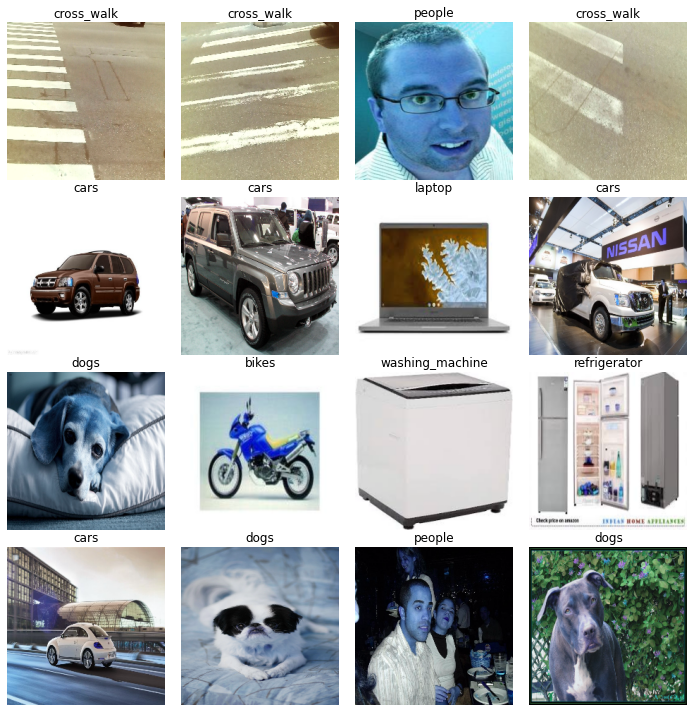

In [5]:
fig = plt.figure(figsize = (10, 10))
columns = 4; rows = 4

# sample random indices of images
index = np.random.randint(0, len(images), size = 16)

for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(images[index[i]])
    plt.title(str(class_labels[labels[index[i]]]))
    plt.axis('off')
plt.tight_layout(w_pad = 0.1, h_pad = 0.1)
plt.show()

## 3. Split data into train and validation sets

In [6]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, 
                                                  test_size = 0.15, 
                                                  stratify = labels, 
                                                  random_state = 42)

print(f'x_train shape: {x_train.shape}\ny_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}\ny_val shape: {y_val.shape}')

x_train shape: (6362, 224, 224, 3)
y_train shape: (6362,)
x_val shape: (1123, 224, 224, 3)
y_val shape: (1123,)


### One hot encode the train and validation labels

In [7]:
y_train = to_categorical(y_train, 11)
y_val = to_categorical(y_val)

y_train.shape, y_val.shape

((6362, 11), (1123, 11))

## 4. Build and train the model

### 4.1 Build CNN model using pre-trained ResNet50 model

In [21]:
# load the base pre-trained model
base_model = ResNet50(weights = 'imagenet', 
                      include_top = False, 
                      input_tensor = Input(shape = (224, 224, 3)))

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# flatten the outputs 
x = Flatten()(x)

# add a fully-connected layer
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)

# Output layer with 37 classes
predictions = Dense(11, activation = 'softmax')(x)

# Final model
model = Model(inputs = base_model.input, outputs = predictions)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

### 4.2 Print the model summary

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### 4.3 Compile and fit the model

In [13]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.fit(x_train, y_train,
          batch_size = 24, 
          validation_data = (x_val, y_val), 
          epochs = 5)

Epoch 1/5
266/266 [==============================] - 39s 148ms/step - loss: 0.3584 - accuracy: 0.8942 - val_loss: 0.0629 - val_accuracy: 0.9822
Epoch 2/5
266/266 [==============================] - 38s 142ms/step - loss: 0.1055 - accuracy: 0.9690 - val_loss: 0.0564 - val_accuracy: 0.9840
Epoch 3/5
266/266 [==============================] - 38s 142ms/step - loss: 0.0805 - accuracy: 0.9742 - val_loss: 0.0528 - val_accuracy: 0.9866
Epoch 4/5
266/266 [==============================] - 38s 142ms/step - loss: 0.0714 - accuracy: 0.9766 - val_loss: 0.0480 - val_accuracy: 0.9831
Epoch 5/5
266/266 [==============================] - 38s 142ms/step - loss: 0.0571 - accuracy: 0.9808 - val_loss: 0.0420 - val_accuracy: 0.9884


### 4.4 Plot the loss and accuracy of training and validation data

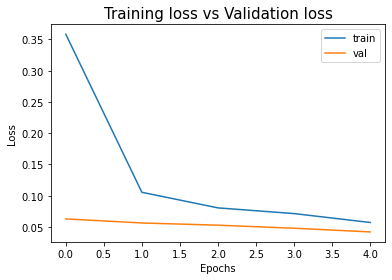

In [14]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Training loss vs Validation loss', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val']);

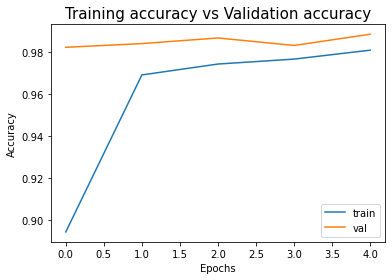

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Training accuracy vs Validation accuracy', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val']);

## 5. Fine tune the model

### 5.1 Train the last two blocks of the ResNet50 model

In [17]:
# Make last two blocks of the base_model trainable
for layer in base_model.layers[:155]:
    layer.trainable = False
    
for layer in base_model.layers[155:]:
    layer.trainable = True

print('Last two block of the base_model are now trainable')

Last two block of the base_model are now trainable


In [18]:
# compile the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# fit the model
model.fit(x_train, y_train, 
          batch_size = 24, 
          validation_data = (x_val, y_val), 
          epochs = 6)

Epoch 1/6
266/266 [==============================] - 46s 174ms/step - loss: 0.3759 - accuracy: 0.9041 - val_loss: 1.3826 - val_accuracy: 0.9083
Epoch 2/6
266/266 [==============================] - 46s 171ms/step - loss: 0.1569 - accuracy: 0.9643 - val_loss: 0.1199 - val_accuracy: 0.9715
Epoch 3/6
266/266 [==============================] - 46s 172ms/step - loss: 0.0870 - accuracy: 0.9774 - val_loss: 0.0650 - val_accuracy: 0.9893
Epoch 4/6
266/266 [==============================] - 46s 172ms/step - loss: 0.0960 - accuracy: 0.9807 - val_loss: 0.0683 - val_accuracy: 0.9866
Epoch 5/6
266/266 [==============================] - 46s 172ms/step - loss: 0.0746 - accuracy: 0.9794 - val_loss: 0.0824 - val_accuracy: 0.9858
Epoch 6/6
266/266 [==============================] - 46s 171ms/step - loss: 0.0895 - accuracy: 0.9772 - val_loss: 0.1124 - val_accuracy: 0.9813


### 5.2 Plot the loss and accuracy of training and validation data

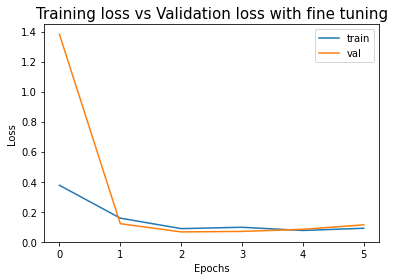

In [19]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Training loss vs Validation loss with fine tuning', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val']);

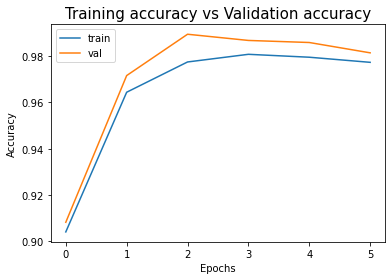

In [20]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Training accuracy vs Validation accuracy', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val']);

## 6. Train the model with data augmentation

### 6.1 Image data augmentation to reduce overfitting

In [22]:
# Training data augmentation using image data generator
train_Aug = ImageDataGenerator(width_shift_range = 0.1, 
                               height_shift_range = 0.1, 
                               zoom_range = 0.1, 
                               shear_range = 0.1, 
                               rotation_range = 10, 
                               fill_mode = 'nearest')

# validation data augmentation
val_Aug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) 
mean = np.array([123.68, 116.779, 103.939], dtype = "float32")
train_Aug.mean = mean
val_Aug.mean = mean

# compile and fit the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# fit the model
history = model.fit(x = train_Aug.flow(x_train, y_train, batch_size = 24), 
                    validation_data = val_Aug.flow(x_val, y_val), 
                    steps_per_epoch = len(x_train) // 24, 
                    epochs = 8)

Epoch 1/8
265/265 [==============================] - 69s 259ms/step - loss: 0.4441 - accuracy: 0.8687 - val_loss: 0.0678 - val_accuracy: 0.9777
Epoch 2/8
265/265 [==============================] - 61s 231ms/step - loss: 0.1535 - accuracy: 0.9560 - val_loss: 0.0634 - val_accuracy: 0.9786
Epoch 3/8
265/265 [==============================] - 66s 248ms/step - loss: 0.1328 - accuracy: 0.9604 - val_loss: 0.0555 - val_accuracy: 0.9840
Epoch 4/8
265/265 [==============================] - 60s 228ms/step - loss: 0.1023 - accuracy: 0.9697 - val_loss: 0.0455 - val_accuracy: 0.9849
Epoch 5/8
265/265 [==============================] - 63s 237ms/step - loss: 0.1040 - accuracy: 0.9705 - val_loss: 0.0556 - val_accuracy: 0.9858
Epoch 6/8
265/265 [==============================] - 61s 230ms/step - loss: 0.0856 - accuracy: 0.9713 - val_loss: 0.0505 - val_accuracy: 0.9849
Epoch 7/8
265/265 [==============================] - 61s 229ms/step - loss: 0.0701 - accuracy: 0.9765 - val_loss: 0.0628 - val_accuracy:

### 6.2 Plot the loss and accuracy of training and validation data

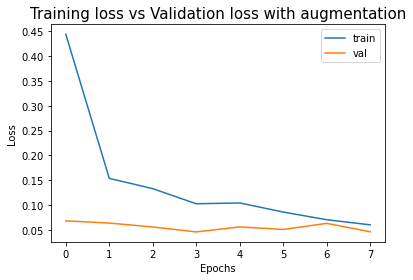

In [25]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Training loss vs Validation loss with augmentation', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val']);

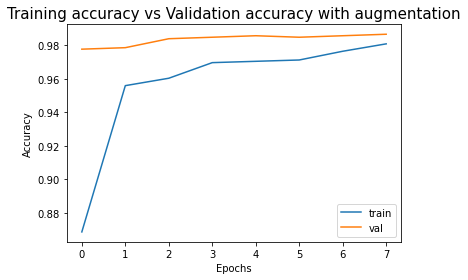

In [26]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Training accuracy vs Validation accuracy with augmentation', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val']);

## 7. Model predictions 

### 7.1 Prepare test data for predictions

In [27]:
# path of test data
test_path = 'Test_Data'   

test_data = []
# preprocess the test data for the model

for path in os.listdir(test_path):
    img = cv2.imread(os.path.join(test_path, path))
    # Convert from BGR to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # OpenCV didn't read some images
    test_data.append(cv2.resize(img, size))

### 7.2 Make and display predictions on test data

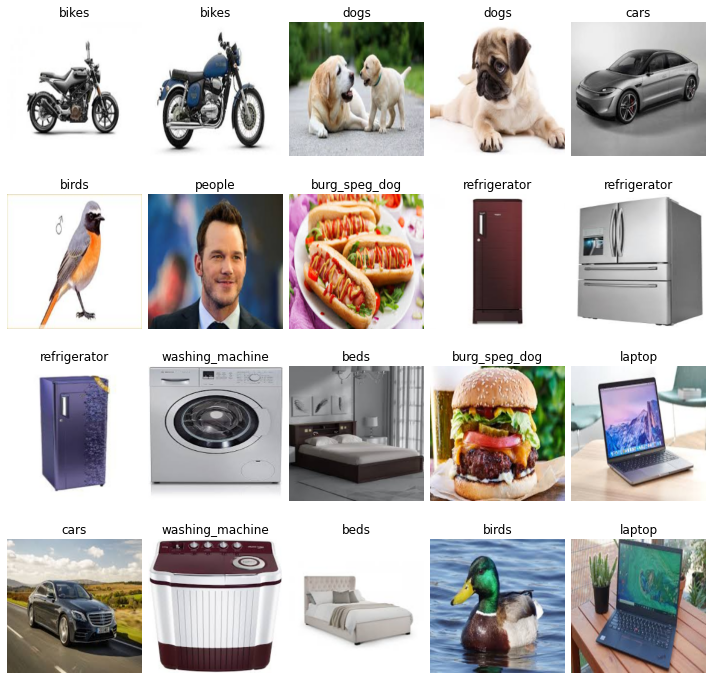

In [29]:
test_data = np.array(test_data)
predictions = np.argmax(model.predict(test_data), axis = -1)

fig = plt.figure(figsize = (10, 10))
columns = 5; rows = 4 

for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(test_data[i])
    plt.title(str(class_labels[predictions[i]]))
    plt.axis('off')
plt.tight_layout(w_pad = 0.1, h_pad = 0.1)
plt.show()